<div style="padding:1em;background-color:#61223B;color:white;text-align:center;">
    <h1>Kalman Filters and Sensor Fusion</h1>
   <h3>Assignment 2: Non-linear and Non-parametric Filters</h3>
</div>

The purpose of this assignment is to implement and test different non-linear and non-parametric filters on a general robotic problem. The assignment aims to give you a broad range of experience with three different algorithms. To enable this, a lot of the "prep work" has been completed for you. The assignment is structured as follows:
- Information about the problem
- Task A: Implement an Extended Kalman Filter (EKF) 
- Task B: Implement an Unscented Kalman Filter (UKF) 
- Task C: Implement a Partical Filter (PF)
- Task D: Experiment with using the Particle Fitler to localise an autonomous racing car 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat

from utils import *
from Gaussian import Gaussian
from RoverRobot import RoverRobot

<h3 style="margin-bottom:1em;border-bottom:solid 3px #61223B">Information: The Rover Robot</h3>

We work the the problem of estimating the location of an autonomous rover with non-linear dynamics given by:

$$\begin{bmatrix}
x_k \\
y _k\\
\theta_k 
\end{bmatrix}=\begin{bmatrix}
x_{k-1}+T_s v_{k-1}\cos(\theta_{k-1}) \\
y_{k-1}+T_s v_{k-1}\sin(\theta_{k-1}) \\
\theta_{k-1} + T_s v_{k-1}\frac{\phi_{k-1}}{d} \\
\end{bmatrix}+\mathbf{w}_{k}$$

where $d=0.5$ m is the length of the robot, and $\phi_{k-1}$ is the steering angle. The process noise $\mathbf{w}_{k}$ is zero-mean Gaussian with covariance $Q=\text{diag}([0.2^2, 0.2^2, 0.05^2])$ and the sampling frequency is 2 Hz.

To aid its localisation, the vehicle also receives distance and bearing measurements from a stationary beacon at the coordinates $(x_B,y_B)$ = (20, 15). 

$$
\begin{bmatrix}
r_{k} \\
\beta_{k}
\end{bmatrix}=\begin{bmatrix}
\sqrt{(x_k-x_B)^2+(y_k-y_B)^2} \\
\text{atan2}\left(y_k-y_B,x_k-x_B\right)-\theta_k
\end{bmatrix}
$$

where the measurement noise $\mathbf{w}_{k}$ is zero-mean Gaussian with covariance $R=\text{diag}([1^2, 0.04^2])$.

We already implement an "RoverRobot" class that contains the dynamic model of the vehicle (f), the measurement model (h), and the Jacobian of the motion (F_k) and measurement (H_k) models. 


In [2]:
#Problem setup code
Q = np.diag([0.2**2, 0.2**2, 0.05**2])
R = np.diag([1**2, 0.04**2])
f_s = 2
T = 25
init_state = np.array([0,0,-np.pi/3])
init_belief = Gaussian(init_state, np.diag([2**2,2**2,0.1**2]))

def simulate_rover_robot(robot, filter):
    controls = np.sin(np.arange(0, T*f_s+ 1, 1/f_s) * 0.2)  *0.08
    for k in range (1,T*f_s+1):
        control = controls[k]
        robot.move(control)
        filter.control_update(control)
        measurement = robot.measure()
        if measurement is not None:
            filter.measurement_update(measurement)


<h3 style="margin-bottom:1em;border-bottom:solid 3px #61223B">Task A: Extended Kalman Filter</h3>

This task is to implement the Extended Kalman Filter for the autonomous car.
We provide a base class for which you should implement the methods:
1. `control_update()`
2. `measure_update()`

We provide a `simulate_car()` method to test your filter.

In [3]:
# Implement the EKF code here.
class ExtendedKalmanFilter:
    def __init__(self, init_belief, f, h, F_k, H_k, Q, R):
        self.beliefs = [init_belief]
        self.prior = None
        self.f = f
        self.h = h
        self.F_k = F_k
        self.H_k = H_k
        self.Q = Q
        self.R = R

    def control_update(self, u):
        # Insert code here to perform the measurement update and calculate the prior

    def measurement_update(self, y):
        # Inserset code here to use the measurement to update the prior into the belief
    
    def get_estimated_states(self):
        states = [belief.get_mean() for belief in self.beliefs]
        return np.array(states)
    
    

Deadreckon MAE: 4.6801 m --> Estimated MAE: 0.7290 m


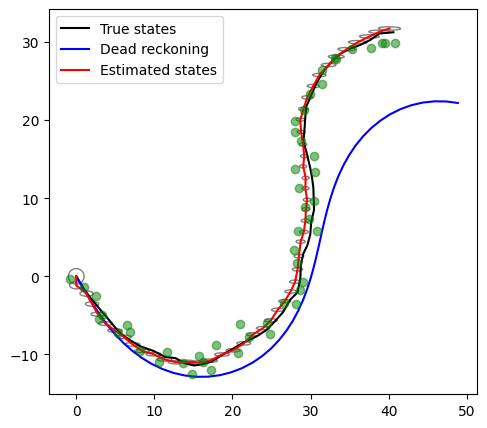

In [4]:
#Driver code for EKF
ekf_robot = RoverRobot(init_state, Q, R, 1/f_s)
ekf = ExtendedKalmanFilter(init_belief, ekf_robot.f, ekf_robot.h, ekf_robot.F_k, ekf_robot.H_k, Q, R)

simulate_rover_robot(ekf_robot, ekf)

plot_estimation_belief(ekf_robot, ekf)


<h3 style="margin-bottom:1em;border-bottom:solid 3px #61223B">Task B: Unscented Kalman Filter</h3>

This task is to implement the Unscented Kalman Filter for the autonomous car.
We provide a base class for which you should implement the methods:
1. `control_update()`
2. `measure_update()`

We provide driver code to test your filter. We also provide the function `get_moments_from_sigma_points()` which returns the means, covariance and cross-covariance for two sets of points.

In [5]:

class UnscentedKalmanFilter:
    def __init__(self, init_belief, f, h, Q, R):
        self.beliefs = [init_belief]
        self.prior = None
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R

    def control_update(self, u):
        # Insert code here for the motion update

    def measurement_update(self, y):
        #Insert code here for the measurement update

    def get_estimated_states(self):
        states = [belief.get_mean() for belief in self.beliefs]
        return np.array(states)
    
    def get_moments_from_sigma_points(self, init_points, final_points):
        n = init_points.shape[1]
        m = final_points.shape[1]
        mean = np.zeros(m)
        cov = np.zeros((m,m))
        cross = np.zeros((n,m))
        for i in range (2*n+1):
            if i == 0:
                w_m = 1 - n
            else:
                w_m = 1/2
            mean += w_m * final_points[i]
        for i in range (2*n+1):
            if i == 0:
                w_c = 4 - n - 1/n
            else:
                w_c = 1/2
            diff = final_points[i] - mean
            cov += w_c * np.outer(diff, diff)
            cross += w_c * np.outer(init_points[i] - init_points[0], diff)
        return mean, cov, cross
    

Deadreckon MAE: 1.3118 m --> Estimated MAE: 0.6332 m


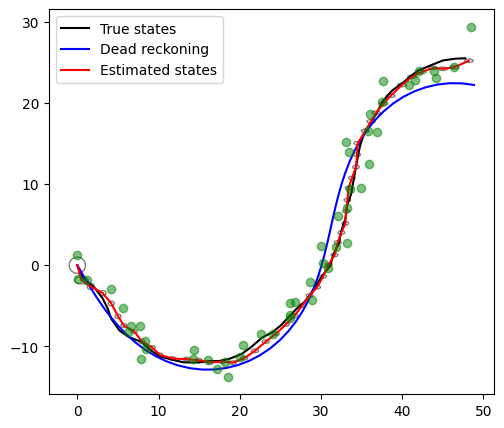

In [6]:
# Driver code for UKF

ukf_robot = RoverRobot(init_state, Q, R, 1/f_s)
ukf = UnscentedKalmanFilter(init_belief, ukf_robot.f, ukf_robot.h, Q, R)

simulate_rover_robot(ukf_robot, ukf)

plot_estimation_belief(ukf_robot, ukf)


<h3 style="margin-bottom:1em;border-bottom:solid 3px #61223B">Task C: Particle Filter</h3>

This task is to implement the  Filter for the autonomous car.
We provide a base class for which you should implement the methods:
1. `control_update()`
2. `measure_update()`

We provide a driver code to test your filter. For the particle filter, the measurement update should include calculating the estimated belief and resampling the particles using the new weights.

In [7]:

class ParticleFilter:
    def __init__(self, init_belief, f, h, Q, R, NP) -> None:
        self.estimates = [init_belief.get_mean()]
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
        self.NP = NP

        self.particles = init_belief.draw_samples(self.NP)
        self.proposal_distribution = self.particles 
        self.weights = np.ones(self.NP) / self.NP
        self.particle_indices = np.arange(self.NP)

    def control_update(self, control):
        # Write code here the control update

    def measurement_update(self, measurement):
        # write coede here for the measurement update
        # estimate the belief
        # resample the particles

    def get_estimated_states(self):
        return np.array(self.estimates)



Deadreckon MAE: 4.7358 m --> Estimated MAE: 1.1974 m


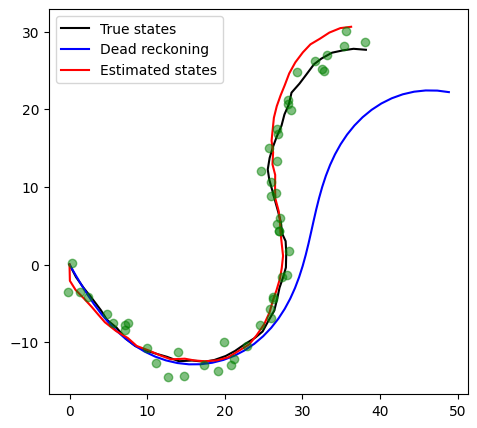

In [8]:

NP = 200
pf_robot = RoverRobot(init_state, Q, R, 1/f_s)
pf = ParticleFilter(init_belief, pf_robot.f, pf_robot.h, Q, R, NP)

simulate_rover_robot(pf_robot, pf)

plot_estimation(pf_robot, pf)

<h3 style="margin-bottom:1em;border-bottom:solid 3px #61223B">Task D: Experiment with Particle Filter Localisation</h3>

One of the most common applications of the particle filter in robotics is LiDAR-localisation. The task of localisation is to determine the vehicle's position on a map. The deadreckoning odometry (which is subject to drift) is combined with measurements from the LiDAR. The LiDAR scan measurements are used to correct the estimates.

The particle filter is well suited to the problem of localisation since the the distribution of particle is not Guassian, but depends on the map.

This task applies the particle filter that has already been built to the localisation task and requires the parameters, such as number of particles to be tuned.
The task is to localise the position of an autonomous racing car on a race track.

In [9]:
from AutonomousRacer import AutonomousRacer

T = 31
def simulate_racing(robot, filter, f_s):
    for k in range (1,T*f_s+1):
        control = robot.move()
        filter.control_update(control)
        measurement = robot.measure()
        if measurement is not None:
            filter.measurement_update(measurement)


Q = np.diag([0.1**2, 0.1**2, 0.05**2])
R = np.diag([0.2**2])

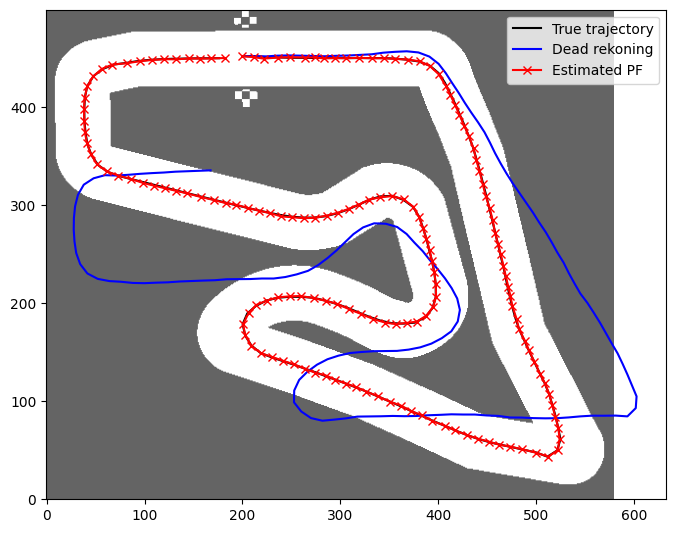

MAE: 0.0458 cm


In [10]:
NP = 50

f_s = 5
init_state = np.array([0,0, 0])
init_belief = Gaussian(init_state, np.diag([0.8**2, 0.8**2, 0.05**2]))
robot = AutonomousRacer(init_state, 1/f_s)
particle_filter = ParticleFilter(init_belief, robot.f, robot.h, Q, R, NP)

simulate_racing(robot, particle_filter, f_s)

true_states, noisy_states = robot.get_states()
estimates = particle_filter.get_estimated_states()
plot_racing_localistion(estimates, true_states, noisy_states, robot)

mae = np.mean(np.abs(true_states - estimates))
print(f"MAE: {mae:.4f} cm")


The next task is to measure the effect of the number of particles used on the accuracy and computational requirements of the particle filter.
Code is provided that prints the mean absolute error and run time of the `measurement_update()` function.

Use the function to record the cumulative computation time and the MAE when using 5, 20, 50, 500 and 5000 particles. You may want to run several tests at each point and take an average of the times.

In [13]:
import cProfile, pstats, io
def profile_particle_filter(number_of_particles):
    print(f"Testing with {number_of_particles} particles")
    Q = np.diag([0.1**2, 0.1**2, 0.05**2])
    R = np.diag([0.1**2])

    f_s = 5
    init_state = np.array([0,0, 0])
    init_belief = Gaussian(init_state, np.diag([0.8**2, 0.8**2, 0.05**2]))

    def measure_compute():
        robot = AutonomousRacer(init_state, 1/f_s)
        particle_filter = ParticleFilter(init_belief, robot.f, robot.h, Q, R, number_of_particles)
        
        simulate_racing(robot, particle_filter, f_s)

        true_states, _noisy_states = robot.get_states()
        return true_states, particle_filter.get_estimated_states()

    pr = cProfile.Profile()
    pr.enable()
    true_states, estimates = measure_compute()
    pr.disable()
    
    ps = pstats.Stats(pr).strip_dirs().sort_stats('cumulative')
    ps.print_stats('measurement_update')

    print(f"Mean absolute error: {np.mean(np.abs(true_states - estimates)):.4f} cm")

    print(f"--------------------------------------------")


In [14]:
# write code here to measure the accuracy and computation time for different numbers of particles


Testing with 5 particles
         174423 function calls (173616 primitive calls) in 0.241 seconds

   Ordered by: cumulative time
   List reduced from 416 to 1 due to restriction <'measurement_update'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      155    0.006    0.000    0.157    0.001 845547796.py:20(measurement_update)


Mean absolute error: 0.1560 cm
--------------------------------------------
Testing with 20 particles
         512580 function calls (511773 primitive calls) in 0.584 seconds

   Ordered by: cumulative time
   List reduced from 416 to 1 due to restriction <'measurement_update'>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      155    0.006    0.000    0.505    0.003 845547796.py:20(measurement_update)


Mean absolute error: 0.0701 cm
--------------------------------------------
Testing with 50 particles
         1188858 function calls (1188051 primitive calls) in 1.299 seconds

   Ordered by: cumulative t